Import dependencies and configure settings.

In [1]:
import os
import csv
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import statsmodels.api as sm
import math

import hawkes
import markDistributions as md
import scipy.optimize as op

from pylab import rcParams
from __future__ import division

%matplotlib inline
np.set_printoptions(precision=10)

Load GOOG order message data with 10 price levels into dict, taking only order events between 1100 and 1200.

In [2]:
dat = 'GOOG_2012-06-21_34200000_57600000_message_10'
temp = ([],[],[],[],[],[])
with open('../../data/'+dat+'.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temp[0].append(float(row[0]))
        temp[1].append(int(row[1]))
        temp[2].append(int(row[2]))
        temp[3].append(int(row[3]))
        temp[4].append(int(row[4]))
        temp[5].append(int(row[5]))

orders = {'Time':None, 'Type':None, 'Order ID':None,
        'Volume':None, 'Price':None, 'Direction':None}
orders['Time'] = np.asarray(temp[0])
orders['Type'] = np.asarray(temp[1])
orders['Order ID'] = np.asarray(temp[2])
orders['Volume'] = np.asarray(temp[3])
orders['Price'] = np.asarray(temp[4])
orders['Direction'] = np.asarray(temp[5])
del temp

In [3]:
orders['Time'] = orders['Time'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Type'] = orders['Type'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Order ID'] = orders['Order ID'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Volume'] = orders['Volume'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Price'] = orders['Price'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Direction'] = orders['Direction'][(orders['Time']>39600) & (orders['Time']<43200)]

In [4]:
ttemp = len(orders['Type'])
print("{0} order messages total:".format(len(orders['Type'])))
temp = len(orders['Type'][orders['Type']==1])
print("- {0} LO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==2])
print("- {0} partial LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==3])
print("- {0} LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==4])
print("- {0} visible LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==5])
print("- {0} hidden LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==7])
print("- {0} trading halts ({1:.2f}%)".format(temp,100*temp/ttemp))
del ttemp
del temp

20573 order messages total:
- 9963 LO submissions (48.43%)
- 4 partial LO cancellations (0.02%)
- 9419 LO cancellations (45.78%)
- 654 visible LO execution (3.18%)
- 533 hidden LO execution (2.59%)
- 0 trading halts (0.00%)


Extract data into usable form.

In [5]:
LTC_mask = (orders['Type']==1) | (orders['Type']==3) | (orders['Type']==4)
t = orders['Time'][LTC_mask]
x = orders['Volume'][LTC_mask]

tmp = orders['Type'][LTC_mask]
j = np.zeros(len(tmp))
j[(tmp==1) & (orders['Direction'][LTC_mask]==-1)] = 0 # limit ask orders
j[(tmp==1) & (orders['Direction'][LTC_mask]==1)] = 1 # limit bid orders
j[(tmp==4) & (orders['Direction'][LTC_mask]==1)] = 2 # market ask orders
j[(tmp==4) & (orders['Direction'][LTC_mask]==-1)] = 3 # market bid orders
j[(tmp==3)] = 4 # cancellation order

del tmp

Fit a Pareto distribution to the volumes. There may be a math range error, which is a bug to be solved. Just re-run it.

In [6]:
mv = []
for i in xrange(5):
    mv.append(md.ParetoLinear())
    result = mv[i].MLE(x[j==i],method='L-BFGS-B')
    print result['x']

[ 472.1402866429    6.326692116 ]
[ 1651.3639857412    21.7848899281]
[ 609.4908037158    9.3863973728]
[ 4319.2482825206    68.4119066038]
[ 1663.2030969775    20.4691866879]


Comparing the distributions.

5


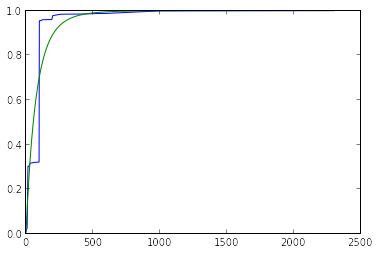

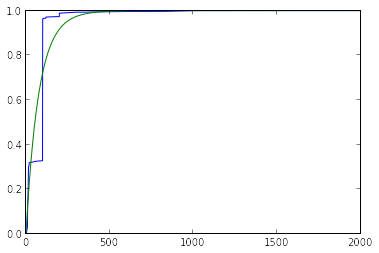

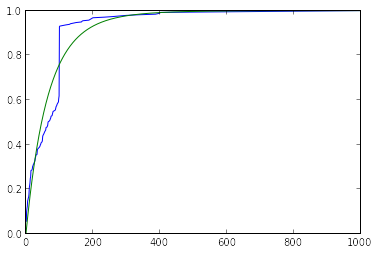

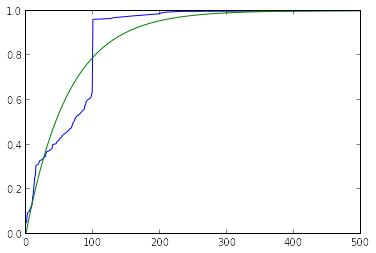

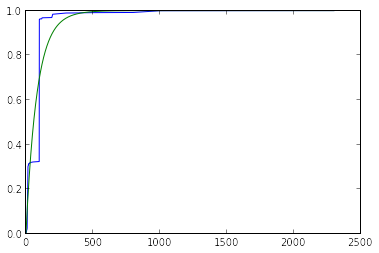

In [7]:
for h in xrange(len(mv)):
    k = np.zeros(max(x[j==h]))
    for i in xrange(max(x[j==h])):
        k[i] = mv[h].CumulativeDistribution(i)

    ecdf = sm.distributions.ECDF(x[j==h])
    q = np.sort(x[j==h])
    r = ecdf(q)

    plt.plot(q, r)
    plt.plot(xrange(max(x[j==h])), k)
    plt.show()